In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, recall_score, precision_score, f1_score
import seaborn as sns
import torch
from kan import KAN
import matplotlib.pyplot as plt

import scikitplot as skplt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score


In [7]:
validation_df = pd.read_csv('dataset_tratado/validation_df.csv')
train_df = pd.read_csv('dataset_tratado/train_df.csv')
test_df = pd.read_csv('dataset_tratado/train_df.csv')

In [8]:
train_df.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Class_Eco,Class_Eco Plus,Departure Delay Category_10 minutos até 30 minutos,Departure Delay Category_30 min até 1 hora,Departure Delay Category_Mais de 1 hora,Departure Delay Category_Menos de 10 minutos,Arrival Delay Category_10 minutos até 30 minutos,Arrival Delay Category_30 min até 1 hora,Arrival Delay Category_Mais de 1 hora,Arrival Delay Category_Menos de 10 minutos
0,0.307692,0.052302,0.8,1.0,1.0,0.6,0.4,1.0,0.4,0.4,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.564103,0.511712,0.4,0.4,0.4,0.4,0.6,0.8,1.0,0.8,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.551282,0.073506,0.4,0.4,0.4,0.4,0.8,0.4,0.6,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.256410,0.270800,0.8,0.8,0.8,0.6,0.4,0.8,0.4,0.4,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.294872,0.188611,1.0,0.2,0.2,0.2,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [9]:
X_train = train_df.drop(columns=['satisfied']).values
y_train = train_df['satisfied'].values

In [10]:
X_test = test_df.drop(columns=['satisfied']).values
y_test = test_df['satisfied'].values

## Transformando os dataframes em tensores

In [11]:
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.long)

In [12]:
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.long)

In [13]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

## Inicializando e treinando a rede KAN

In [14]:
model = KAN(width=[X_train.shape[1], 2], grid=3, k=3)

Directory already exists: ./model


In [49]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

In [50]:
results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 4.77e+01 : 100%|██| 20/20 [05:57<00:00, 17.86s/it]


Visualizando o modelo

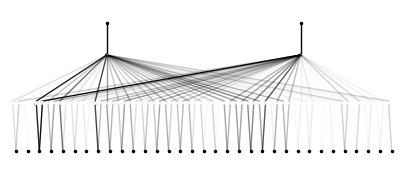

In [52]:
model.plot()

Resultados

In [41]:
def extract_final_losses(results):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    results -- Dicionário contendo as perdas de treino e validação durante o treinamento.
    
    Retorno:
    Dicionário contendo o menor loss de treino e de validação.
    """
    train_loss = results['train_loss']
    val_loss = results['test_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(results):
    """Função para plotar as curvas de erro do treinamento da rede neural KAN.
    
    Argumento(s):
    results -- Dicionário contendo as perdas de treino e validação durante o treinamento.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = results['train_loss']
    val_loss = results['test_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Test Error Curves', xlabel='Steps', ylabel='Loss')
    ax.legend()
    plt.show()


def compute_performance_metrics(y_test, y_pred_class, y_pred_scores=None):
    """Calcula as métricas de desempenho e plota a estatística KS.
    
    Argumento(s):
    y_test -- Rótulos verdadeiros.
    y_pred_class -- Rótulos preditos.
    y_pred_scores -- Pontuações preditas (opcional).
    
    Retorno:
    Tupla contendo as métricas de desempenho.
    """
    # Calcular acurácia
    accuracy = accuracy_score(y_test, y_pred_class)
    
    # Calcular precisão, recall e F1-score
    recall = recall_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y_test, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y_test, y_pred_scores)
        aupr = average_precision_score(y_test, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    """Imprime um resumo das métricas de desempenho.
    
    Argumento(s):
    accuracy -- Acurácia.
    recall -- Recall.
    precision -- Precisão.
    f1 -- F1-score.
    auroc -- AUROC (opcional).
    aupr -- AUPR (opcional).
    
    Retorno:
    A função imprime as métricas e retorna None.
    """
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

Acurácia final no conjunto de treino: 0.9353
Acurácia final no conjunto de teste: 0.9353
MSE: 0.06467508469356328
Test Recall: 0.91519862851738
Test Precision: 0.9344781795134907
Test F1-Score: 0.9247379267090762


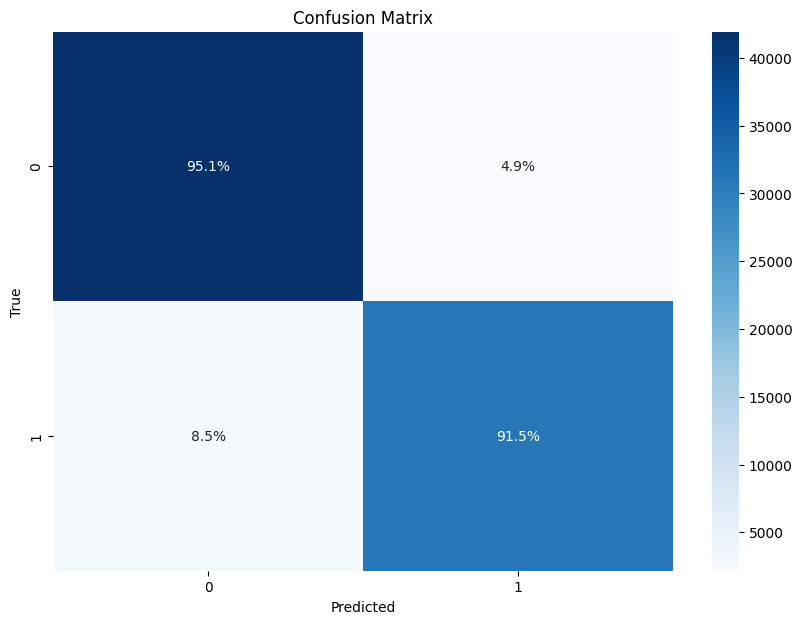

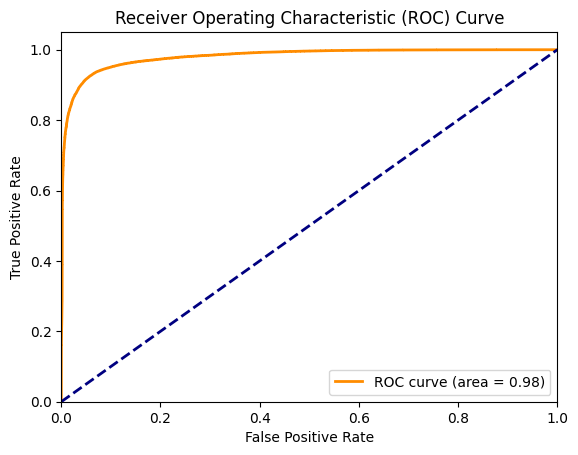

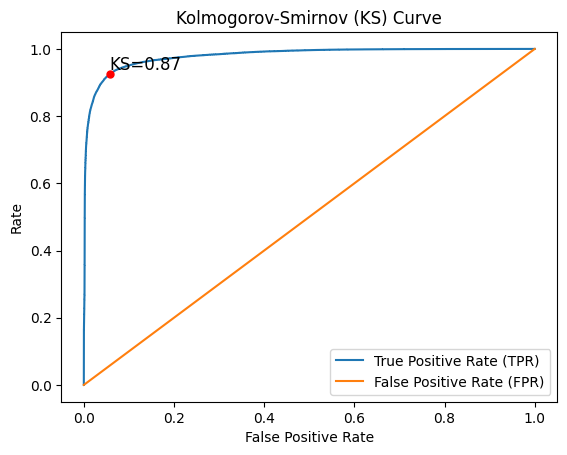

KS Statistic: 0.87
Final Training Loss: 0.41819957
Final test Loss: 0.41819957


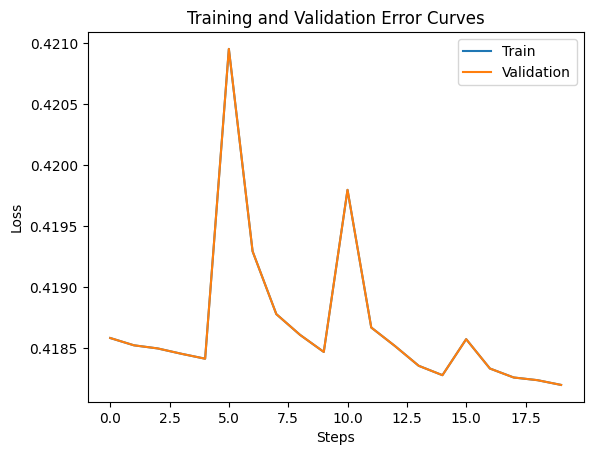

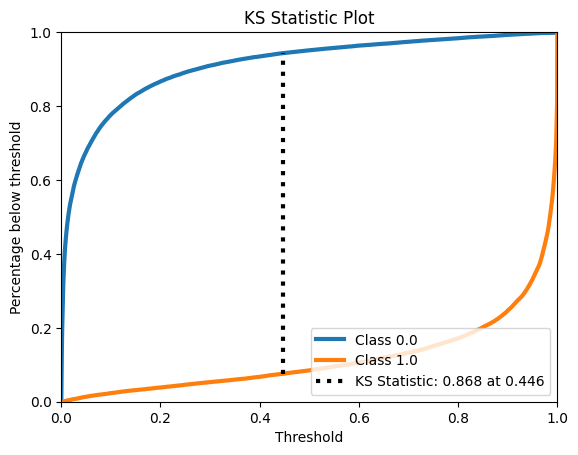


Accuracy:         0.9353
Recall:           0.9152
Precision:        0.9345
F1:               0.9247
AUROC:            0.9801
AUPR:             0.9762


In [54]:
# Avaliação do modelo final
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]
print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

# Cálculo do MSE e outras métricas
test_outputs = model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()
mse = mean_squared_error(y_test, test_predictions)
print(f"MSE: {mse}")

test_recall = recall_score(y_test, test_predictions)
print("Test Recall:", test_recall)

test_precision = precision_score(y_test, test_predictions)
print("Test Precision:", test_precision)

test_f1 = f1_score(y_test, test_predictions)
print("Test F1-Score:", test_f1)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, test_predictions)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC e KS Statistic
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_test, test_probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='bottom')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")

# Utilização das funções auxiliares
losses = extract_final_losses(results)
print("Final Training Loss:", losses['train_loss'])
print("Final test Loss:", losses['val_loss'])

plot_training_error_curves(results)

# Cálculo das métricas de desempenho
performance_metrics = compute_performance_metrics(y_test, test_predictions, test_probs)
print_metrics_summary(*performance_metrics)


## Grid Search

In [27]:
def train_and_evaluate_model(width, grid, k, steps, opt):
    model = KAN(width=width, grid=grid, k=k)

    # Funções de avaliação
    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

    results = model.train(dataset, opt=opt, steps=steps, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())
    final_train_acc = results['train_acc'][-1]
    final_test_acc = results['test_acc'][-1]
    return final_train_acc, final_test_acc

Definindo a grade de busca

In [28]:
param_grid = {
    'width': [[X_train.shape[1], 2]],
    'grid': [2, 3, 4],
    'k': [2, 3, 4],
    'steps': [10, 20, 30, 50, 100],
    'opt' : ['LBFGS', 'Adam']
}

In [32]:
best_params = None
best_accuracy = 0

# Iterar sobre todas as combinações de hiperparâmetros
for width in param_grid['width']:
    for grid in param_grid['grid']:
        for k in param_grid['k']:
            for opt in param_grid['opt']:
                for steps in param_grid['steps']:
                    train_acc, test_acc = train_and_evaluate_model(width, grid, k, steps, opt)
                    print(f"Width: {width}, Grid: {grid}, K: {k}, Steps: {steps}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
                    
                    if test_acc > best_accuracy:
                        best_accuracy = test_acc
                        best_params = {'width': width, 'grid': grid, 'k': k, 'steps': steps, 'opt':opt}

Directory already exists: ./model


train loss: 4.37e-01 | test loss: 4.37e-01 | reg: 4.55e+01 : 100%|██| 10/10 [02:17<00:00, 13.74s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 2, Steps: 10, Train Acc: 0.9268, Test Acc: 0.9268
Directory already exists: ./model


train loss: 4.37e-01 | test loss: 4.37e-01 | reg: 4.53e+01 : 100%|██| 20/20 [04:02<00:00, 12.13s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 2, Steps: 20, Train Acc: 0.9269, Test Acc: 0.9269
Directory already exists: ./model


train loss: 4.37e-01 | test loss: 4.37e-01 | reg: 4.55e+01 : 100%|██| 30/30 [05:44<00:00, 11.50s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 2, Steps: 30, Train Acc: 0.9269, Test Acc: 0.9269
Directory already exists: ./model


train loss: 4.37e-01 | test loss: 4.37e-01 | reg: 4.54e+01 : 100%|██| 50/50 [06:45<00:00,  8.10s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 2, Steps: 50, Train Acc: 0.9269, Test Acc: 0.9269
Directory already exists: ./model


train loss: 4.37e-01 | test loss: 4.37e-01 | reg: 4.56e+01 : 100%|█| 100/100 [10:28<00:00,  6.28s/it


Width: [[33, 0], [2, 0]], Grid: 2, K: 2, Steps: 100, Train Acc: 0.9269, Test Acc: 0.9269
Directory already exists: ./model


train loss: 9.09e-01 | test loss: 9.51e-01 | reg: 9.30e+01 : 100%|██| 10/10 [00:15<00:00,  1.53s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 2, Steps: 10, Train Acc: 0.8307, Test Acc: 0.8307
Directory already exists: ./model


train loss: 7.58e-01 | test loss: 8.99e-01 | reg: 1.32e+02 : 100%|██| 20/20 [00:30<00:00,  1.54s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 2, Steps: 20, Train Acc: 0.8764, Test Acc: 0.8764
Directory already exists: ./model


train loss: 6.27e-01 | test loss: 6.73e-01 | reg: 1.21e+02 : 100%|██| 30/30 [00:45<00:00,  1.53s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 2, Steps: 30, Train Acc: 0.8971, Test Acc: 0.8971
Directory already exists: ./model


train loss: 6.61e-01 | test loss: 6.41e-01 | reg: 9.59e+01 : 100%|██| 50/50 [01:17<00:00,  1.55s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 2, Steps: 50, Train Acc: 0.8366, Test Acc: 0.8366
Directory already exists: ./model


train loss: 4.41e-01 | test loss: 4.41e-01 | reg: 8.98e+01 : 100%|█| 100/100 [02:30<00:00,  1.51s/it


Width: [[33, 0], [2, 0]], Grid: 2, K: 2, Steps: 100, Train Acc: 0.9264, Test Acc: 0.9264
Directory already exists: ./model


train loss: 4.28e-01 | test loss: 4.28e-01 | reg: 4.76e+01 : 100%|██| 10/10 [02:48<00:00, 16.89s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 3, Steps: 10, Train Acc: 0.9331, Test Acc: 0.9331
Directory already exists: ./model


train loss: 4.24e-01 | test loss: 4.24e-01 | reg: 5.15e+01 : 100%|██| 20/20 [05:36<00:00, 16.81s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 3, Steps: 20, Train Acc: 0.9342, Test Acc: 0.9342
Directory already exists: ./model


train loss: 4.24e-01 | test loss: 4.24e-01 | reg: 5.03e+01 : 100%|██| 30/30 [08:55<00:00, 17.84s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 3, Steps: 30, Train Acc: 0.9341, Test Acc: 0.9341
Directory already exists: ./model


train loss: 4.23e-01 | test loss: 4.23e-01 | reg: 5.08e+01 : 100%|██| 50/50 [14:54<00:00, 17.88s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 3, Steps: 50, Train Acc: 0.9341, Test Acc: 0.9341
Directory already exists: ./model


train loss: 4.23e-01 | test loss: 4.23e-01 | reg: 5.62e+01 : 100%|█| 100/100 [27:39<00:00, 16.60s/it


Width: [[33, 0], [2, 0]], Grid: 2, K: 3, Steps: 100, Train Acc: 0.9344, Test Acc: 0.9344
Directory already exists: ./model


train loss: 8.65e-01 | test loss: 8.30e-01 | reg: 6.88e+01 : 100%|██| 10/10 [00:22<00:00,  2.22s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 3, Steps: 10, Train Acc: 0.8578, Test Acc: 0.8578
Directory already exists: ./model


train loss: 7.05e-01 | test loss: 9.44e-01 | reg: 9.25e+01 : 100%|██| 20/20 [00:42<00:00,  2.13s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 3, Steps: 20, Train Acc: 0.8074, Test Acc: 0.8074
Directory already exists: ./model


train loss: 7.42e-01 | test loss: 6.35e-01 | reg: 1.01e+02 : 100%|██| 30/30 [01:08<00:00,  2.29s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 3, Steps: 30, Train Acc: 0.9000, Test Acc: 0.9000
Directory already exists: ./model


train loss: 5.15e-01 | test loss: 4.93e-01 | reg: 8.28e+01 : 100%|██| 50/50 [01:52<00:00,  2.25s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 3, Steps: 50, Train Acc: 0.9144, Test Acc: 0.9144
Directory already exists: ./model


train loss: 4.33e-01 | test loss: 4.33e-01 | reg: 7.27e+01 : 100%|█| 100/100 [03:32<00:00,  2.12s/it


Width: [[33, 0], [2, 0]], Grid: 2, K: 3, Steps: 100, Train Acc: 0.9298, Test Acc: 0.9298
Directory already exists: ./model


train loss: 4.33e-01 | test loss: 4.33e-01 | reg: 4.68e+01 : 100%|██| 10/10 [03:40<00:00, 22.03s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 4, Steps: 10, Train Acc: 0.9283, Test Acc: 0.9283
Directory already exists: ./model


train loss: 4.28e-01 | test loss: 4.28e-01 | reg: 5.81e+01 : 100%|██| 20/20 [07:40<00:00, 23.00s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 4, Steps: 20, Train Acc: 0.9324, Test Acc: 0.9324
Directory already exists: ./model


train loss: 4.42e-01 | test loss: 4.42e-01 | reg: 6.47e+01 : 100%|██| 30/30 [11:07<00:00, 22.24s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 4, Steps: 30, Train Acc: 0.9245, Test Acc: 0.9245
Directory already exists: ./model


train loss: 4.27e-01 | test loss: 4.27e-01 | reg: 8.33e+01 : 100%|██| 50/50 [18:56<00:00, 22.73s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 4, Steps: 50, Train Acc: 0.9323, Test Acc: 0.9323
Directory already exists: ./model


train loss: 4.20e-01 | test loss: 4.20e-01 | reg: 1.11e+02 : 100%|█| 100/100 [36:09<00:00, 21.69s/it


Width: [[33, 0], [2, 0]], Grid: 2, K: 4, Steps: 100, Train Acc: 0.9350, Test Acc: 0.9350
Directory already exists: ./model


train loss: 8.30e-01 | test loss: 8.35e-01 | reg: 6.40e+01 : 100%|██| 10/10 [00:26<00:00,  2.65s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 4, Steps: 10, Train Acc: 0.7607, Test Acc: 0.7607
Directory already exists: ./model


train loss: 9.90e-01 | test loss: 8.74e-01 | reg: 9.47e+01 : 100%|██| 20/20 [00:55<00:00,  2.75s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 4, Steps: 20, Train Acc: 0.8518, Test Acc: 0.8518
Directory already exists: ./model


train loss: 6.69e-01 | test loss: 6.73e-01 | reg: 9.39e+01 : 100%|██| 30/30 [01:25<00:00,  2.85s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 4, Steps: 30, Train Acc: 0.8651, Test Acc: 0.8651
Directory already exists: ./model


train loss: 5.09e-01 | test loss: 5.39e-01 | reg: 7.84e+01 : 100%|██| 50/50 [22:50<00:00, 27.40s/it]


Width: [[33, 0], [2, 0]], Grid: 2, K: 4, Steps: 50, Train Acc: 0.8805, Test Acc: 0.8805
Directory already exists: ./model


train loss: 4.37e-01 | test loss: 4.38e-01 | reg: 8.35e+01 : 100%|█| 100/100 [04:59<00:00,  3.00s/it


Width: [[33, 0], [2, 0]], Grid: 2, K: 4, Steps: 100, Train Acc: 0.9276, Test Acc: 0.9276
Directory already exists: ./model


train loss: 4.23e-01 | test loss: 4.23e-01 | reg: 4.67e+01 : 100%|██| 10/10 [02:31<00:00, 15.19s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 2, Steps: 10, Train Acc: 0.9343, Test Acc: 0.9343
Directory already exists: ./model


train loss: 4.23e-01 | test loss: 4.23e-01 | reg: 4.72e+01 : 100%|██| 20/20 [05:03<00:00, 15.18s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 2, Steps: 20, Train Acc: 0.9346, Test Acc: 0.9346
Directory already exists: ./model


train loss: 4.22e-01 | test loss: 4.22e-01 | reg: 4.82e+01 : 100%|██| 30/30 [07:04<00:00, 14.14s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 2, Steps: 30, Train Acc: 0.9345, Test Acc: 0.9345
Directory already exists: ./model


train loss: 4.22e-01 | test loss: 4.22e-01 | reg: 4.87e+01 : 100%|██| 50/50 [11:30<00:00, 13.80s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 2, Steps: 50, Train Acc: 0.9344, Test Acc: 0.9344
Directory already exists: ./model


train loss: 4.22e-01 | test loss: 4.22e-01 | reg: 4.89e+01 : 100%|█| 100/100 [16:29<00:00,  9.90s/it


Width: [[33, 0], [2, 0]], Grid: 3, K: 2, Steps: 100, Train Acc: 0.9343, Test Acc: 0.9343
Directory already exists: ./model


train loss: 1.09e+00 | test loss: 1.33e+00 | reg: 1.33e+02 : 100%|██| 10/10 [00:16<00:00,  1.62s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 2, Steps: 10, Train Acc: 0.8441, Test Acc: 0.8441
Directory already exists: ./model


train loss: 9.62e-01 | test loss: 9.99e-01 | reg: 1.63e+02 : 100%|██| 20/20 [00:33<00:00,  1.67s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 2, Steps: 20, Train Acc: 0.8710, Test Acc: 0.8710
Directory already exists: ./model


train loss: 6.76e-01 | test loss: 6.36e-01 | reg: 1.27e+02 : 100%|██| 30/30 [00:50<00:00,  1.67s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 2, Steps: 30, Train Acc: 0.8974, Test Acc: 0.8974
Directory already exists: ./model


train loss: 4.53e-01 | test loss: 4.50e-01 | reg: 9.07e+01 : 100%|██| 50/50 [01:23<00:00,  1.67s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 2, Steps: 50, Train Acc: 0.9257, Test Acc: 0.9257
Directory already exists: ./model


train loss: 4.42e-01 | test loss: 4.54e-01 | reg: 9.11e+01 : 100%|█| 100/100 [02:39<00:00,  1.60s/it


Width: [[33, 0], [2, 0]], Grid: 3, K: 2, Steps: 100, Train Acc: 0.9225, Test Acc: 0.9225
Directory already exists: ./model


train loss: 4.21e-01 | test loss: 4.21e-01 | reg: 4.72e+01 : 100%|██| 10/10 [02:49<00:00, 16.95s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 3, Steps: 10, Train Acc: 0.9340, Test Acc: 0.9340
Directory already exists: ./model


train loss: 4.19e-01 | test loss: 4.19e-01 | reg: 4.83e+01 : 100%|██| 20/20 [05:51<00:00, 17.57s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 3, Steps: 20, Train Acc: 0.9352, Test Acc: 0.9352
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 4.87e+01 : 100%|██| 30/30 [08:50<00:00, 17.69s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 3, Steps: 30, Train Acc: 0.9352, Test Acc: 0.9352
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 4.94e+01 : 100%|██| 50/50 [15:07<00:00, 18.14s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 3, Steps: 50, Train Acc: 0.9355, Test Acc: 0.9355
Directory already exists: ./model


train loss: 4.17e-01 | test loss: 4.17e-01 | reg: 5.41e+01 : 100%|█| 100/100 [27:35<00:00, 16.55s/it


Width: [[33, 0], [2, 0]], Grid: 3, K: 3, Steps: 100, Train Acc: 0.9356, Test Acc: 0.9356
Directory already exists: ./model


train loss: 1.07e+00 | test loss: 1.35e+00 | reg: 1.12e+02 : 100%|██| 10/10 [00:21<00:00,  2.11s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 3, Steps: 10, Train Acc: 0.8407, Test Acc: 0.8407
Directory already exists: ./model


train loss: 1.04e+00 | test loss: 1.09e+00 | reg: 1.42e+02 : 100%|██| 20/20 [00:45<00:00,  2.26s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 3, Steps: 20, Train Acc: 0.8560, Test Acc: 0.8560
Directory already exists: ./model


train loss: 6.85e-01 | test loss: 7.09e-01 | reg: 1.14e+02 : 100%|██| 30/30 [01:08<00:00,  2.28s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 3, Steps: 30, Train Acc: 0.9017, Test Acc: 0.9017
Directory already exists: ./model


train loss: 4.61e-01 | test loss: 4.52e-01 | reg: 7.47e+01 : 100%|██| 50/50 [01:57<00:00,  2.36s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 3, Steps: 50, Train Acc: 0.9251, Test Acc: 0.9251
Directory already exists: ./model


train loss: 4.68e-01 | test loss: 4.70e-01 | reg: 7.29e+01 : 100%|█| 100/100 [03:43<00:00,  2.23s/it


Width: [[33, 0], [2, 0]], Grid: 3, K: 3, Steps: 100, Train Acc: 0.9142, Test Acc: 0.9142
Directory already exists: ./model


train loss: 4.23e-01 | test loss: 4.23e-01 | reg: 4.70e+01 : 100%|██| 10/10 [03:36<00:00, 21.68s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 4, Steps: 10, Train Acc: 0.9349, Test Acc: 0.9349
Directory already exists: ./model


train loss: 4.21e-01 | test loss: 4.21e-01 | reg: 4.74e+01 : 100%|██| 20/20 [07:22<00:00, 22.14s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 4, Steps: 20, Train Acc: 0.9347, Test Acc: 0.9347
Directory already exists: ./model


train loss: 4.21e-01 | test loss: 4.21e-01 | reg: 5.01e+01 : 100%|██| 30/30 [11:23<00:00, 22.77s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 4, Steps: 30, Train Acc: 0.9349, Test Acc: 0.9349
Directory already exists: ./model


train loss: 4.21e-01 | test loss: 4.21e-01 | reg: 5.12e+01 : 100%|██| 50/50 [18:52<00:00, 22.65s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 4, Steps: 50, Train Acc: 0.9349, Test Acc: 0.9349
Directory already exists: ./model


train loss: 4.19e-01 | test loss: 4.19e-01 | reg: 5.24e+01 : 100%|█| 100/100 [2:56:22<00:00, 105.83s


Width: [[33, 0], [2, 0]], Grid: 3, K: 4, Steps: 100, Train Acc: 0.9354, Test Acc: 0.9354
Directory already exists: ./model


train loss: 1.26e+00 | test loss: 1.70e+00 | reg: 1.10e+02 : 100%|██| 10/10 [00:31<00:00,  3.11s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 4, Steps: 10, Train Acc: 0.7967, Test Acc: 0.7967
Directory already exists: ./model


train loss: 8.24e-01 | test loss: 9.46e-01 | reg: 1.22e+02 : 100%|██| 20/20 [01:03<00:00,  3.17s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 4, Steps: 20, Train Acc: 0.8764, Test Acc: 0.8764
Directory already exists: ./model


train loss: 7.45e-01 | test loss: 6.98e-01 | reg: 1.23e+02 : 100%|██| 30/30 [01:35<00:00,  3.19s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 4, Steps: 30, Train Acc: 0.9110, Test Acc: 0.9110
Directory already exists: ./model


train loss: 6.88e-01 | test loss: 5.18e-01 | reg: 9.50e+01 : 100%|██| 50/50 [02:39<00:00,  3.19s/it]


Width: [[33, 0], [2, 0]], Grid: 3, K: 4, Steps: 50, Train Acc: 0.9135, Test Acc: 0.9135
Directory already exists: ./model


train loss: 4.42e-01 | test loss: 4.40e-01 | reg: 9.02e+01 : 100%|█| 100/100 [05:17<00:00,  3.17s/it


Width: [[33, 0], [2, 0]], Grid: 3, K: 4, Steps: 100, Train Acc: 0.9258, Test Acc: 0.9258
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 4.76e+01 : 100%|██| 10/10 [03:09<00:00, 18.92s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 2, Steps: 10, Train Acc: 0.9350, Test Acc: 0.9350
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 4.95e+01 : 100%|██| 20/20 [06:03<00:00, 18.16s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 2, Steps: 20, Train Acc: 0.9354, Test Acc: 0.9354
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 5.10e+01 : 100%|██| 30/30 [08:51<00:00, 17.71s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 2, Steps: 30, Train Acc: 0.9355, Test Acc: 0.9355
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 5.07e+01 : 100%|██| 50/50 [16:47<00:00, 20.15s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 2, Steps: 50, Train Acc: 0.9355, Test Acc: 0.9355
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 5.16e+01 : 100%|█| 100/100 [22:49<00:00, 13.70s/it


Width: [[33, 0], [2, 0]], Grid: 4, K: 2, Steps: 100, Train Acc: 0.9355, Test Acc: 0.9355
Directory already exists: ./model


train loss: 1.07e+00 | test loss: 1.15e+00 | reg: 1.69e+02 : 100%|██| 10/10 [00:22<00:00,  2.25s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 2, Steps: 10, Train Acc: 0.8530, Test Acc: 0.8530
Directory already exists: ./model


train loss: 8.85e-01 | test loss: 8.11e-01 | reg: 2.14e+02 : 100%|██| 20/20 [00:47<00:00,  2.38s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 2, Steps: 20, Train Acc: 0.9047, Test Acc: 0.9047
Directory already exists: ./model


train loss: 7.49e-01 | test loss: 6.64e-01 | reg: 2.15e+02 : 100%|██| 30/30 [01:14<00:00,  2.49s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 2, Steps: 30, Train Acc: 0.9308, Test Acc: 0.9308
Directory already exists: ./model


train loss: 7.90e-01 | test loss: 8.75e-01 | reg: 1.91e+02 : 100%|██| 50/50 [01:50<00:00,  2.21s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 2, Steps: 50, Train Acc: 0.8987, Test Acc: 0.8987
Directory already exists: ./model


train loss: 4.56e-01 | test loss: 4.41e-01 | reg: 1.10e+02 : 100%|█| 100/100 [03:31<00:00,  2.11s/it


Width: [[33, 0], [2, 0]], Grid: 4, K: 2, Steps: 100, Train Acc: 0.9266, Test Acc: 0.9266
Directory already exists: ./model


train loss: 4.20e-01 | test loss: 4.20e-01 | reg: 4.81e+01 : 100%|██| 10/10 [03:27<00:00, 20.71s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 3, Steps: 10, Train Acc: 0.9345, Test Acc: 0.9345
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 4.80e+01 : 100%|██| 20/20 [07:24<00:00, 22.21s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 3, Steps: 20, Train Acc: 0.9354, Test Acc: 0.9354
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 4.83e+01 : 100%|██| 30/30 [10:40<00:00, 21.34s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 3, Steps: 30, Train Acc: 0.9354, Test Acc: 0.9354
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 5.03e+01 : 100%|██| 50/50 [17:14<00:00, 20.68s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 3, Steps: 50, Train Acc: 0.9354, Test Acc: 0.9354
Directory already exists: ./model


train loss: 4.17e-01 | test loss: 4.17e-01 | reg: 6.02e+01 : 100%|█| 100/100 [33:34<00:00, 20.14s/it


Width: [[33, 0], [2, 0]], Grid: 4, K: 3, Steps: 100, Train Acc: 0.9355, Test Acc: 0.9355
Directory already exists: ./model


train loss: 1.08e+00 | test loss: 1.60e+00 | reg: 1.55e+02 : 100%|██| 10/10 [00:27<00:00,  2.75s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 3, Steps: 10, Train Acc: 0.8134, Test Acc: 0.8134
Directory already exists: ./model


train loss: 8.71e-01 | test loss: 9.85e-01 | reg: 1.52e+02 : 100%|██| 20/20 [00:57<00:00,  2.86s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 3, Steps: 20, Train Acc: 0.8804, Test Acc: 0.8804
Directory already exists: ./model


train loss: 7.09e-01 | test loss: 6.27e-01 | reg: 1.36e+02 : 100%|██| 30/30 [01:26<00:00,  2.88s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 3, Steps: 30, Train Acc: 0.9173, Test Acc: 0.9173
Directory already exists: ./model


train loss: 5.18e-01 | test loss: 4.96e-01 | reg: 1.01e+02 : 100%|██| 50/50 [02:22<00:00,  2.85s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 3, Steps: 50, Train Acc: 0.9183, Test Acc: 0.9183
Directory already exists: ./model


train loss: 4.25e-01 | test loss: 4.25e-01 | reg: 9.08e+01 : 100%|█| 100/100 [04:28<00:00,  2.68s/it


Width: [[33, 0], [2, 0]], Grid: 4, K: 3, Steps: 100, Train Acc: 0.9343, Test Acc: 0.9343
Directory already exists: ./model


train loss: 4.19e-01 | test loss: 4.19e-01 | reg: 4.82e+01 : 100%|██| 10/10 [04:15<00:00, 25.52s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 4, Steps: 10, Train Acc: 0.9353, Test Acc: 0.9353
Directory already exists: ./model


train loss: 4.19e-01 | test loss: 4.19e-01 | reg: 4.80e+01 : 100%|██| 20/20 [08:46<00:00, 26.30s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 4, Steps: 20, Train Acc: 0.9350, Test Acc: 0.9350
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 4.86e+01 : 100%|██| 30/30 [13:01<00:00, 26.03s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 4, Steps: 30, Train Acc: 0.9352, Test Acc: 0.9352
Directory already exists: ./model


train loss: 4.18e-01 | test loss: 4.18e-01 | reg: 5.36e+01 : 100%|██| 50/50 [21:29<00:00, 25.80s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 4, Steps: 50, Train Acc: 0.9355, Test Acc: 0.9355
Directory already exists: ./model


train loss: 4.17e-01 | test loss: 4.17e-01 | reg: 6.79e+01 : 100%|█| 100/100 [42:22<00:00, 25.43s/it


Width: [[33, 0], [2, 0]], Grid: 4, K: 4, Steps: 100, Train Acc: 0.9356, Test Acc: 0.9356
Directory already exists: ./model


train loss: 1.44e+00 | test loss: 9.69e-01 | reg: 1.21e+02 : 100%|██| 10/10 [00:34<00:00,  3.43s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 4, Steps: 10, Train Acc: 0.8738, Test Acc: 0.8738
Directory already exists: ./model


train loss: 1.70e+00 | test loss: 1.62e+00 | reg: 1.84e+02 : 100%|██| 20/20 [01:10<00:00,  3.55s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 4, Steps: 20, Train Acc: 0.8053, Test Acc: 0.8053
Directory already exists: ./model


train loss: 8.51e-01 | test loss: 8.75e-01 | reg: 1.18e+02 : 100%|██| 30/30 [01:46<00:00,  3.55s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 4, Steps: 30, Train Acc: 0.8544, Test Acc: 0.8544
Directory already exists: ./model


train loss: 7.87e-01 | test loss: 5.91e-01 | reg: 9.37e+01 : 100%|██| 50/50 [02:58<00:00,  3.57s/it]


Width: [[33, 0], [2, 0]], Grid: 4, K: 4, Steps: 50, Train Acc: 0.9054, Test Acc: 0.9054
Directory already exists: ./model


train loss: 4.35e-01 | test loss: 4.32e-01 | reg: 8.89e+01 : 100%|█| 100/100 [05:50<00:00,  3.50s/it

Width: [[33, 0], [2, 0]], Grid: 4, K: 4, Steps: 100, Train Acc: 0.9301, Test Acc: 0.9301


Analise da combinação de parâmetros escolhida

In [33]:
print(f"Best parameters: {best_params}")
print(f"Best test accuracy: {best_accuracy:.4f}")

Best parameters: {'width': [[33, 0], [2, 0]], 'grid': 4, 'k': 4, 'steps': 100, 'opt': 'LBFGS'}
Best test accuracy: 0.9356


Treinamento com os parametros escolhidos no Grid Search

In [34]:
final_model = KAN(width=best_params['width'], grid=best_params['grid'], k=best_params['k'])


Directory already exists: ./model


In [37]:
# Funções de avaliação
def train_acc():
    return torch.mean((torch.argmax(final_model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(final_model(dataset['test_input']), dim=1) == dataset['test_label']).float())

results = final_model.train(dataset, opt=best_params['opt'], steps=best_params['steps'], metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

train loss: 4.17e-01 | test loss: 4.17e-01 | reg: 5.81e+01 : 100%|█| 100/100 [41:45<00:00, 25.05s/it


Avaliação do modelo treinado

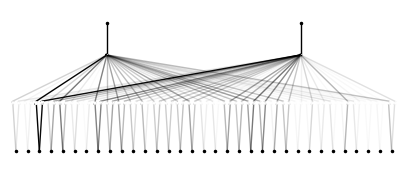

In [38]:
final_model.plot()

Acurácia final no conjunto de treino: 0.9356
Acurácia final no conjunto de teste: 0.9356
MSE: 0.06435427574171029
Test Recall: 0.9155237644833294
Test Precision: 0.9348948115058404
Test F1-Score: 0.9251078954049251


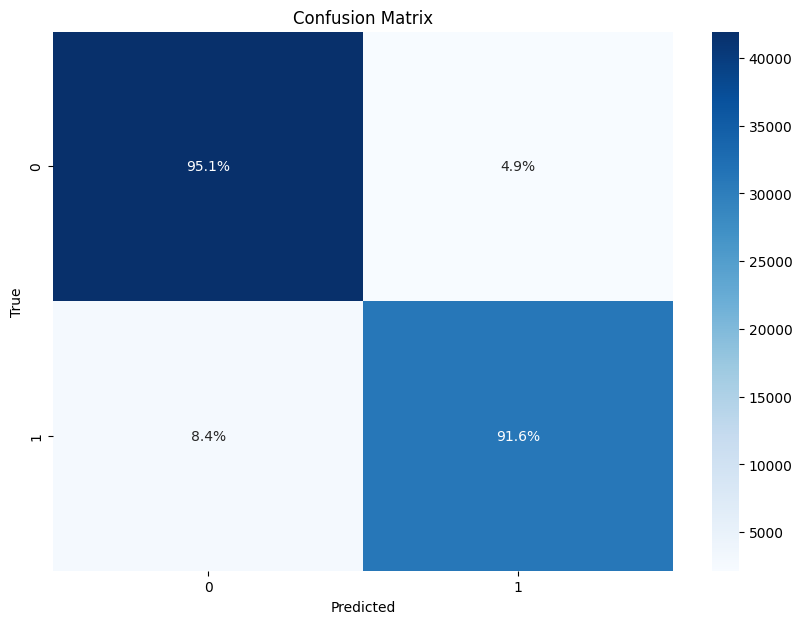

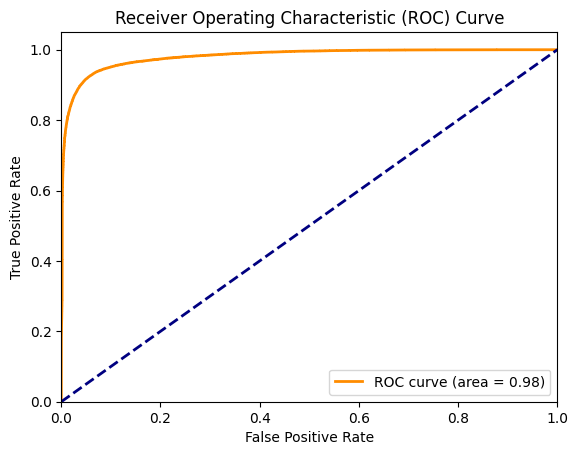

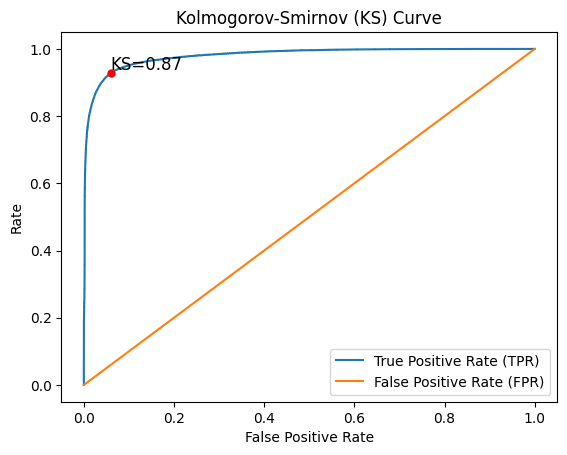

KS Statistic: 0.87
Final Training Loss: 0.41728988
Final test Loss: 0.41728988


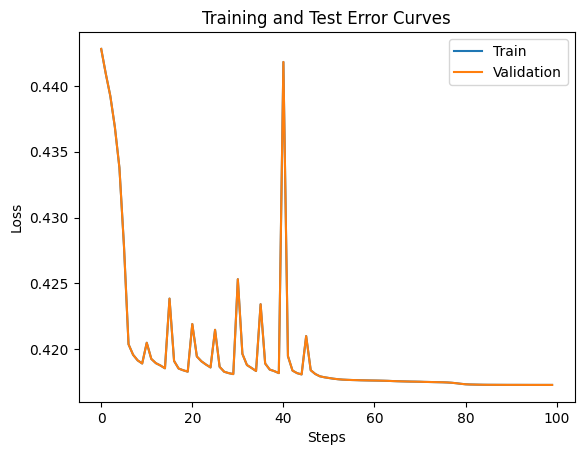

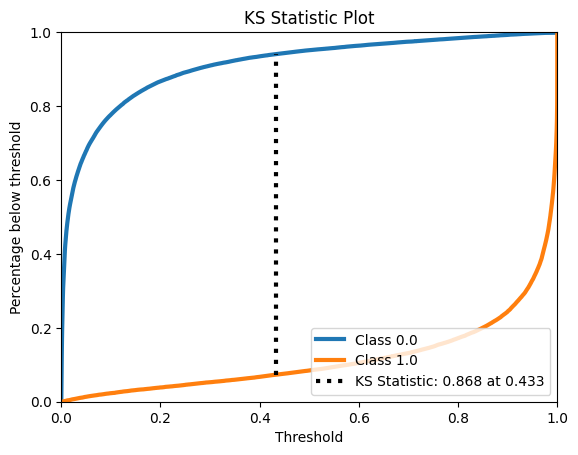


Accuracy:         0.9356
Recall:           0.9155
Precision:        0.9349
F1:               0.9251
AUROC:            0.9803
AUPR:             0.9767


In [42]:
# Avaliação do modelo final
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]
print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

# Cálculo do MSE e outras métricas
test_outputs = final_model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()
mse = mean_squared_error(y_test, test_predictions)
print(f"MSE: {mse}")

test_recall = recall_score(y_test, test_predictions)
print("Test Recall:", test_recall)

test_precision = precision_score(y_test, test_predictions)
print("Test Precision:", test_precision)

test_f1 = f1_score(y_test, test_predictions)
print("Test F1-Score:", test_f1)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, test_predictions)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC e KS Statistic
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_test, test_probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='bottom')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")

# Utilização das funções auxiliares
losses = extract_final_losses(results)
print("Final Training Loss:", losses['train_loss'])
print("Final test Loss:", losses['val_loss'])

plot_training_error_curves(results)

# Cálculo das métricas de desempenho
performance_metrics = compute_performance_metrics(y_test, test_predictions, test_probs)
print_metrics_summary(*performance_metrics)

## Hyperopt

In [23]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import hyperopt.pyll.stochastic


In [24]:
# Função de treinamento e avaliação
def train_and_evaluate(params):
    """Função para treinar e avaliar o modelo KAN usando os parâmetros fornecidos.
    
    Argumento(s):
    params -- Dicionário contendo os parâmetros do modelo e do treinamento.
    
    Retorno:
    Dicionário contendo a perda (negativa da estatística KS), o status, a estatística KS e os parâmetros utilizados.
    """
    # Inicialização do modelo com os parâmetros fornecidos
    model = KAN(width=params['width'], grid=int(params['grid']), k=int(params['k']))
    
    # Funções para calcular a acurácia de treino e teste
    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())
    
    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())
    
    # Treinamento do modelo
    results = model.train(dataset, opt=params['opt'], steps=int(params['steps']), metrics=(train_acc, test_acc))
    
    # Avaliação do modelo no conjunto de teste
    test_outputs = model(dataset['test_input'])
    test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
    fpr, tpr, _ = roc_curve(y_test, test_probs[:, 1])
    ks_statistic = np.max(tpr - fpr)
    
    # Extração das perdas finais para análise
    final_losses = extract_final_losses(results)
    print(f"Final Training Loss: {final_losses['train_loss']}")
    print(f"Final Validation Loss: {final_losses['val_loss']}")
    
    # Plotagem das curvas de erro de treinamento
    plot_training_error_curves(results)
    
    # Cálculo das métricas de desempenho e plotagem da estatística KS
    y_pred_class = torch.argmax(test_outputs, dim=1).numpy()
    performance_metrics = compute_performance_metrics(y_test, y_pred_class, test_probs)
    print_metrics_summary(*performance_metrics)
    
    # Retorno dos resultados para o Hyperopt
    return {'loss': -ks_statistic, 'status': STATUS_OK, 'ks_statistic': ks_statistic, 'params': params}


In [25]:
# Espaço de busca de hiperparâmetros
space = {
    'width': hp.choice('width', [[X_train.shape[1], i] for i in range(1, 10)]),
    'grid': hp.quniform('grid', 2, 4, 1),
    'k': hp.quniform('k', 2, 4, 1),
    'steps': hp.quniform('steps', 10, 100, 10),
    'opt': hp.choice('opt', ['LBFGS', 'Adam'])
}

In [26]:
# Otimização dos hiperparâmetros usando o algoritmo Tree-structured Parzen Estimator (TPE)
trials = Trials()
best = fmin(fn=train_and_evaluate, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Melhores parâmetros encontrados:", best)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: 'tuple' object does not support item assignment



  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


TypeError: 'tuple' object does not support item assignment

In [55]:
# Treinamento final com os melhores parâmetros
best_params = trials.best_trial['result']['params']
final_model = KAN(width=best_params['width'], grid=int(best_params['grid']), k=int(best_params['k']))

def train_acc():
    return torch.mean((torch.argmax(final_model(dataset['train_input']), dim=1) == dataset['train_label']).float())
def test_acc():
    return torch.mean((torch.argmax(final_model(dataset['test_input']), dim=1) == dataset['test_label']).float())

results = final_model.train(dataset, opt=best_params['opt'], steps=int(best_params['steps']), metrics=(train_acc, test_acc))

# Avaliação do modelo final
final_train_acc = results['train_acc'][-1]
final_test_acc = results['test_acc'][-1]
print(f"Acurácia final no conjunto de treino: {final_train_acc:.4f}")
print(f"Acurácia final no conjunto de teste: {final_test_acc:.4f}")

# Cálculo do MSE e outras métricas
test_outputs = final_model(dataset['test_input'])
test_predictions = torch.argmax(test_outputs, dim=1).numpy()
mse = mean_squared_error(y_test, test_predictions)
print(f"MSE: {mse}")

test_recall = recall_score(y_test, test_predictions)
print("Test Recall:", test_recall)

test_precision = precision_score(y_test, test_predictions)
print("Test Precision:", test_precision)

test_f1 = f1_score(y_test, test_predictions)
print("Test F1-Score:", test_f1)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, test_predictions)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
annot_labels = [['{:.1f}%'.format(value) for value in row] for row in conf_matrix_percent]
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=annot_labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Curva ROC e KS Statistic
test_probs = torch.softmax(test_outputs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_test, test_probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='bottom')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")

# Utilização das funções auxiliares
losses = extract_final_losses(results)
print("Final Training Loss:", losses['train_loss'])
print("Final test Loss:", losses['val_loss'])

plot_training_error_curves(results)

# Cálculo das métricas de desempenho
performance_metrics = compute_performance_metrics(y_test, test_predictions, test_probs)
print_metrics_summary(*performance_metrics)


AllTrialsFailed: 

# Explainability

## Global Explainability

## Local Explainability